In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
from google.colab import drive
drive.mount("./gdrive")
#!unzip "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip" -d "./gdrive/My Drive"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [3]:
data_dir='/content/gdrive/My Drive/Assignment 5 Dataset'
#Define transforms for the training data and testing data
img_transforms = transforms.Compose([transforms.Resize([224, 224]),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
#img_transforms = transforms.Compose([transforms.Resize([224, 224]),
 #                                    transforms.ToTensor()])
train_data = datasets.ImageFolder(data_dir + '/train', transform = img_transforms)
test_data = datasets.ImageFolder(data_dir + '/test',  transform = img_transforms)
val_data = datasets.ImageFolder(data_dir + '/validation', transform = img_transforms)
#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=True)
print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


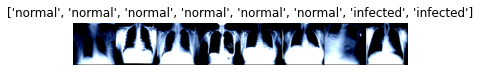

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# **Task 1**

**VGG-16 model**

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

freezing the layers

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

Removing the 3 FC layers

In [0]:
num_features = vgg16.classifier[0].in_features
print(num_features)

vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-7])
print(vgg16)

25088
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

Adding 2 layers

In [4]:
features = list(vgg16.classifier.children())
print(features)

NameError: ignored

In [0]:
features.extend([nn.Linear(num_features, (1*10)+100, bias=True)])
vgg16.classifier = nn.Sequential(*features)

features.extend([nn.ReLU(inplace=True)])
vgg16.classifier = nn.Sequential(*features)

features.extend([nn.Dropout(p=0.5, inplace=False)])
vgg16.classifier = nn.Sequential(*features)


In [0]:
features.extend([nn.Linear((1*10)+100,len(class_names),bias=True)])
vgg16.classifier = nn.Sequential(*features)


In [0]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
loss_training=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                (loss.data)))
      
    torch.save(vgg16.state_dict(), 'vgg16_FC_only.pth')
    loss_training.append(running_loss)

print('Finished Training')

Train Epoch: 0 [11992/12000 (100%)]	Loss: 0.158090: : 1500it [05:31,  4.53it/s]
Train Epoch: 1 [11992/12000 (100%)]	Loss: 0.462054: : 1500it [05:27,  4.58it/s]
Train Epoch: 2 [11992/12000 (100%)]	Loss: 0.095688: : 1500it [05:24,  4.62it/s]
Train Epoch: 3 [11992/12000 (100%)]	Loss: 0.530243: : 1500it [05:23,  4.63it/s]
Train Epoch: 4 [11992/12000 (100%)]	Loss: 0.063142: : 1500it [05:22,  4.65it/s]
Train Epoch: 5 [11992/12000 (100%)]	Loss: 0.083048: : 1500it [05:22,  4.65it/s]
Train Epoch: 6 [11992/12000 (100%)]	Loss: 0.295517: : 1500it [05:21,  4.66it/s]
Train Epoch: 7 [11992/12000 (100%)]	Loss: 0.055914: : 1500it [05:22,  4.65it/s]
Train Epoch: 8 [11992/12000 (100%)]	Loss: 0.152888: : 1500it [05:25,  4.60it/s]
Train Epoch: 9 [11992/12000 (100%)]	Loss: 0.009240: : 1500it [05:31,  4.53it/s]

Finished Training


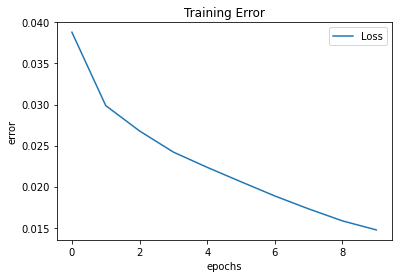

In [0]:
#plot graph of training loss
import matplotlib.pyplot as plt
%matplotlib inline

#print(len(inputs))
losst=[]
for i in range(len(loss_training)):
  losst.append(loss_training[i]/len(trainloader.dataset))

# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('error') 

# giving a title to my graph 
plt.title('Training Error')

plt.plot(np.arange(Epochs),losst,label="Loss")
plt.legend()
plt.show()


In [0]:
from tqdm import notebook
def Accuracy(Model, Loader):
    Model.to(device)
    preds = []
    g_truth = []
    correct = 0
    total = 0
    with torch.no_grad():
        with notebook.tqdm(Loader , leave=False, desc="Predicting ", mininterval=0.5 ) as nt:
            for data in nt:
                img, lbl = data
                img, lbl = img.to(device), lbl.to(device)
                out = Model(img)
                _, pred = torch.max(out.data, 1)
                total += lbl.size(0)
                correct += (pred == lbl).sum().item()
                preds.append(pred)
                g_truth.append(lbl)
                nt.set_postfix(Accuracy = (correct / total))
    return (correct / total), torch.cat(preds), torch.cat(g_truth)

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



Accuracy after fine tuning of FC layers: 94%
Confusion matrix, without normalization
[[552  63]
 [ 27 858]]


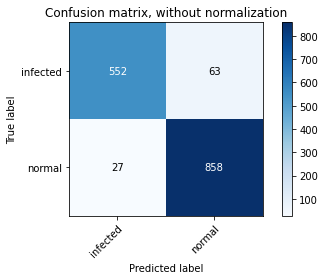

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

accuracy, predictions, g_Truth = Accuracy(vgg16, testloader)

print("Accuracy after fine tuning of FC layers: %d%%" % (100*accuracy))

plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

vgg16.to("cpu")

torch.cuda.empty_cache()

In [0]:
accuracy, predictions, g_Truth = Accuracy(vgg16, trainloader)

print("Accuracy of validation data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")

torch.cuda.empty_cache()
print()

accuracy, predictions, g_Truth = Accuracy(vgg16, valloader)

print("Accuracy of Training data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")

torch.cuda.empty_cache()



Accuracy of calidation data after fine tuning of FC layers: 96%



Accuracy of calidation data after fine tuning of FC layers: 89%


**ResNet-18**

In [0]:
data_dir='/content/gdrive/My Drive/Assignment 5 Dataset'
#Define transforms for the training data and testing data
img_transforms = transforms.Compose([transforms.Resize([224, 224]),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
#img_transforms = transforms.Compose([transforms.Resize([224, 224]),
 #                                    transforms.ToTensor()])
train_data = datasets.ImageFolder(data_dir + '/train', transform = img_transforms)
test_data = datasets.ImageFolder(data_dir + '/test',  transform = img_transforms)
val_data = datasets.ImageFolder(data_dir + '/validation', transform = img_transforms)
#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=True)
print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
#print('Output Layer of Resnet-18 : ', resnet18.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [0]:
# Freeze training for all layers
for param in resnet18.parameters():
    param.requires_grad = False

#for p in resnet18.fc.parameters():
#    p.requires_grad = True

In [0]:
in_features = (resnet18.fc.in_features)
print(in_features)

512


In [0]:
resnet18.fc = nn.Sequential(nn.Linear(in_features, 110), nn.ReLU(inplace=True), nn.Dropout(), nn.Linear(110, len(class_names)))


In [0]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.00001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

losst=[]
resnet18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                (loss.data)))
      
    torch.save(resnet18.state_dict(), 'res18_FC_Only.pth')
    losst.append(running_loss)    
print('Finished Training')

Train Epoch: 0 [11992/12000 (100%)]	Loss: 0.773492: : 1500it [2:11:50,  5.27s/it]
Train Epoch: 1 [11992/12000 (100%)]	Loss: 0.719740: : 1500it [04:21,  5.73it/s]
Train Epoch: 2 [11992/12000 (100%)]	Loss: 0.603545: : 1500it [04:14,  5.88it/s]
Train Epoch: 3 [11992/12000 (100%)]	Loss: 0.463856: : 1500it [04:15,  5.88it/s]
Train Epoch: 4 [11992/12000 (100%)]	Loss: 0.492977: : 1500it [04:16,  5.85it/s]
Train Epoch: 5 [11992/12000 (100%)]	Loss: 0.697370: : 1500it [04:13,  5.91it/s]
Train Epoch: 6 [11992/12000 (100%)]	Loss: 0.480750: : 1500it [04:14,  5.89it/s]
Train Epoch: 7 [11992/12000 (100%)]	Loss: 0.401793: : 1500it [04:23,  5.69it/s]
Train Epoch: 8 [11992/12000 (100%)]	Loss: 0.330406: : 1500it [04:24,  5.68it/s]
Train Epoch: 9 [11992/12000 (100%)]	Loss: 0.160142: : 1500it [04:17,  5.82it/s]


Finished Training


In [0]:
#plot graph of training loss
import matplotlib.pyplot as plt
%matplotlib inline

#print(len(inputs))
losst=[]
for i in range(len(loss_training)):
  losst.append(loss_training[i]/len(trainloader.dataset))

# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('error') 

# giving a title to my graph 
plt.title('Training Error')

plt.plot(np.arange(Epochs),losst,label="Loss")
plt.legend()
plt.show()


In [0]:
from tqdm import notebook
def Accuracy(Model, Loader):
    Model.to(device)
    preds = []
    g_truth = []
    correct = 0
    total = 0
    with torch.no_grad():
        with notebook.tqdm(Loader , leave=False, desc="Predicting ", mininterval=0.5 ) as nt:
            for data in nt:
                img, lbl = data
                img, lbl = img.to(device), lbl.to(device)
                out = Model(img)
                _, pred = torch.max(out.data, 1)
                total += lbl.size(0)
                correct += (pred == lbl).sum().item()
                preds.append(pred)
                g_truth.append(lbl)
                nt.set_postfix(Accuracy = (correct / total))
    return (correct / total), torch.cat(preds), torch.cat(g_truth)

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



Accuracy after fine tuning of FC layers: 83%
Confusion matrix, without normalization
[[454 161]
 [ 82 803]]


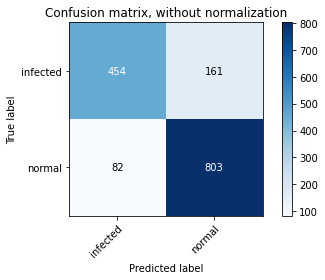

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

accuracy, predictions, g_Truth = Accuracy(resnet18, testloader)

print("Accuracy after fine tuning of FC layers: %d%%" % (100*accuracy))

plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")

torch.cuda.empty_cache()

Accuracy of validation data after fine tuning of FC layers: 81%
Confusion matrix, without normalization
[[3496 1423]
 [ 830 6251]]



Accuracy of Training data after fine tuning of FC layers: 78%
Confusion matrix, without normalization
[[419 196]
 [123 762]]


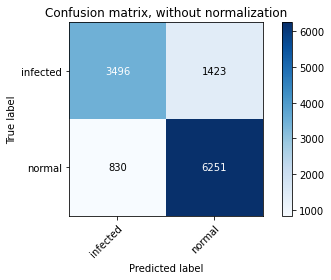

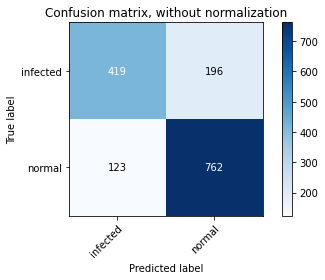

In [0]:
accuracy, predictions, g_Truth = Accuracy(resnet18, trainloader)

print("Accuracy of validation data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")

torch.cuda.empty_cache()
print()

accuracy, predictions, g_Truth = Accuracy(resnet18, valloader)

print("Accuracy of Training data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")

torch.cuda.empty_cache()


# **Task 2**

**VGG-16 model**

In [39]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

freezing the layers

In [0]:
# Freeze training for all layers
#for param in vgg16.features.parameters():
#    param.requires_grad = False

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

In [42]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
loss_training=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                (loss.data)))
      
    torch.save(vgg16.state_dict(), 'vgg16_entire.pth')
    loss_training.append(running_loss)

print('Finished Training')

Train Epoch: 0 [2056/12000 (17%)]	Loss: 0.268031: : 258it [01:07,  3.84it/s]

KeyboardInterrupt: ignored

In [0]:
#plot graph of training loss
import matplotlib.pyplot as plt
%matplotlib inline

#print(len(inputs))
losst=[]
for i in range(len(loss_training)):
  losst.append(loss_training[i]/len(trainloader.dataset))

# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('error') 

# giving a title to my graph 
plt.title('Training Error')

plt.plot(np.arange(Epochs),losst,label="Loss")
plt.legend()
plt.show()


In [0]:
from tqdm import notebook
def Accuracy(Model, Loader):
    Model.to(device)
    preds = []
    g_truth = []
    correct = 0
    total = 0
    with torch.no_grad():
        with notebook.tqdm(Loader , leave=False, desc="Predicting ", mininterval=0.5 ) as nt:
            for data in nt:
                img, lbl = data
                img, lbl = img.to(device), lbl.to(device)
                out = Model(img)
                _, pred = torch.max(out.data, 1)
                total += lbl.size(0)
                correct += (pred == lbl).sum().item()
                preds.append(pred)
                g_truth.append(lbl)
                nt.set_postfix(Accuracy = (correct / total))
    return (correct / total), torch.cat(preds), torch.cat(g_truth)

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

accuracy, predictions, g_Truth = Accuracy(vgg16, testloader)

print("Accuracy after fine tuning of FC layers: %d%%" % (100*accuracy))

plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

vgg16.to("cpu")

torch.cuda.empty_cache()

In [0]:
accuracy, predictions, g_Truth = Accuracy(vgg16, trainloader)

print("Accuracy of validation data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")

torch.cuda.empty_cache()
print()

accuracy, predictions, g_Truth = Accuracy(vgg16, valloader)

print("Accuracy of training data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")

torch.cuda.empty_cache()


In [25]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
#print('Output Layer of Resnet-18 : ', resnet18.classifier[6].out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Freeze training for all layers
#for param in resnet18.parameters():
#    param.requires_grad = False

#for p in resnet18.fc.parameters():
#    p.requires_grad = True

In [27]:
in_features = (resnet18.fc.in_features)
print(in_features)

512


In [0]:
resnet18.fc = nn.Sequential(nn.Linear(in_features, 110), nn.ReLU(inplace=True), nn.Dropout(), nn.Linear(110, len(class_names)))


In [29]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.00001, momentum=0.9)

In [31]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
loss_training=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                (loss.data)))
      
    torch.save(resnet18.state_dict(), 'res18_entire.pth')
    loss_training.append(running_loss)

print('Finished Training')

Train Epoch: 0 [11992/12000 (100%)]	Loss: 0.621328: : 1500it [04:44,  5.28it/s]
Train Epoch: 1 [11992/12000 (100%)]	Loss: 0.370997: : 1500it [04:32,  5.50it/s]
Train Epoch: 2 [11992/12000 (100%)]	Loss: 0.350918: : 1500it [04:29,  5.57it/s]
Train Epoch: 3 [11992/12000 (100%)]	Loss: 0.592694: : 1500it [04:26,  5.62it/s]
Train Epoch: 4 [11992/12000 (100%)]	Loss: 0.234028: : 1500it [04:28,  5.58it/s]
Train Epoch: 5 [11992/12000 (100%)]	Loss: 0.188131: : 1500it [04:28,  5.59it/s]
Train Epoch: 6 [11992/12000 (100%)]	Loss: 0.714054: : 1500it [04:28,  5.59it/s]
Train Epoch: 7 [11992/12000 (100%)]	Loss: 0.074465: : 1500it [04:27,  5.61it/s]
Train Epoch: 8 [11992/12000 (100%)]	Loss: 0.196450: : 1500it [04:27,  5.62it/s]
Train Epoch: 9 [11992/12000 (100%)]	Loss: 0.225227: : 1500it [04:28,  5.59it/s]


Finished Training


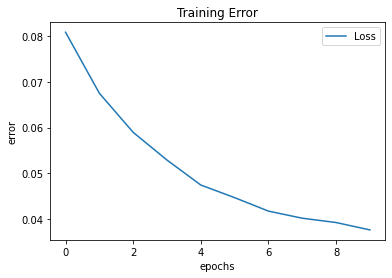

In [32]:
#plot graph of training loss
import matplotlib.pyplot as plt
%matplotlib inline

#print(len(inputs))
losst=[]
for i in range(len(loss_training)):
  losst.append(loss_training[i]/len(trainloader.dataset))

# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('error') 

# giving a title to my graph 
plt.title('Training Error')

plt.plot(np.arange(Epochs),losst,label="Loss")
plt.legend()
plt.show()


In [0]:
from tqdm import notebook
def Accuracy(Model, Loader):
    Model.to(device)
    preds = []
    g_truth = []
    correct = 0
    total = 0
    with torch.no_grad():
        with notebook.tqdm(Loader , leave=False, desc="Predicting ", mininterval=0.5 ) as nt:
            for data in nt:
                img, lbl = data
                img, lbl = img.to(device), lbl.to(device)
                out = Model(img)
                _, pred = torch.max(out.data, 1)
                total += lbl.size(0)
                correct += (pred == lbl).sum().item()
                preds.append(pred)
                g_truth.append(lbl)
                nt.set_postfix(Accuracy = (correct / total))
    return (correct / total), torch.cat(preds), torch.cat(g_truth)

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



Accuracy after fine tuning of FC layers: 91%
Confusion matrix, without normalization
[[542  73]
 [ 50 835]]


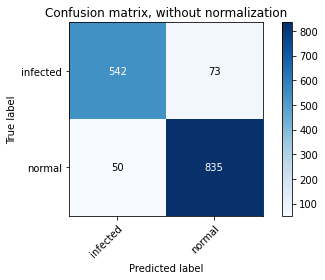

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

accuracy, predictions, g_Truth = Accuracy(resnet18, testloader)

print("Accuracy after fine tuning of FC layers: %d%%" % (100*accuracy))

plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")

torch.cuda.empty_cache()

Accuracy of validation data after fine tuning of FC layers: 88%
Confusion matrix, without normalization
[[4168  751]
 [ 615 6466]]



Accuracy of training data after fine tuning of FC layers: 86%
Confusion matrix, without normalization
[[497 118]
 [ 81 804]]


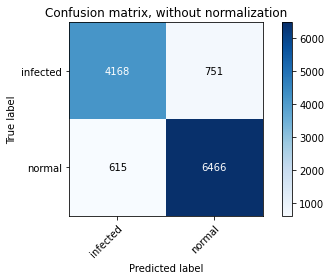

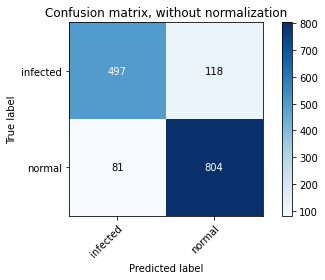

In [36]:
accuracy, predictions, g_Truth = Accuracy(resnet18, trainloader)

print("Accuracy of validation data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")

torch.cuda.empty_cache()
print()

accuracy, predictions, g_Truth = Accuracy(resnet18, valloader)

print("Accuracy of training data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")

torch.cuda.empty_cache()
